## Greenland Grid System

Here I'm going to look into setting up a grid to use for the dHdt project.  I'm going to investigate how many laser shots I get in each cell depending on the grid spacing.  The grid will be in the EPSG:3413 (N. Polar Sterographic) projection. As boundaries for Greenland I'm going to use the same bounds I used when setting up the `gla06_034_grn` table, -90 - 5 longitude and 55 to 85 latitude.

Having experimented with both the ICESAT data and the ATM data, I may need to set up different grids depending on the data density.  Let's start by using a grid of 20km x 20km which is probably too coarse but which should give at least some laser shots for each grid cell.

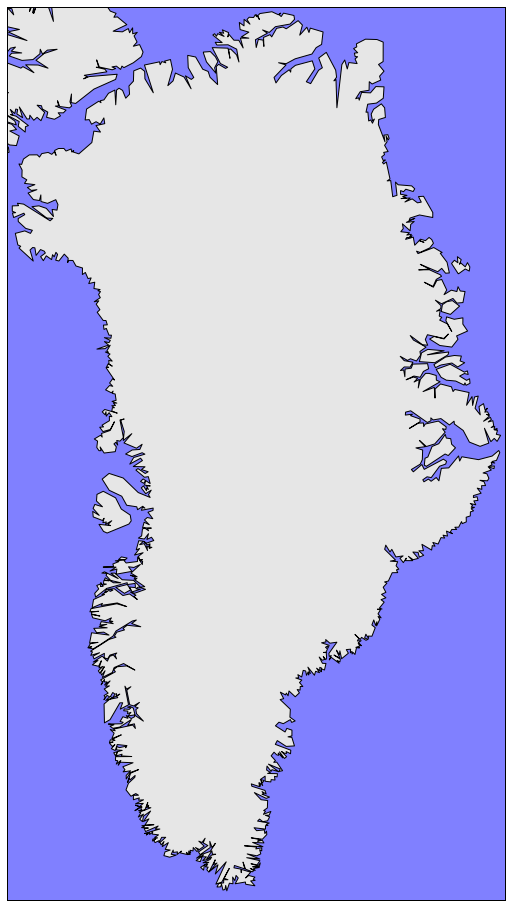

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# try to display same using basemap
from mpl_toolkits.basemap import Basemap

# GIMP bounding box from gdalinfo on 180m tiff file
gimp_bbox = (-639985.000, -3355565.000, 855815.000, -655565.000)
psx_ll, psy_ll, psx_ur, psy_ur = gimp_bbox

# gdalinfo also converts these to lat lon values

# make a simple map of Greenland
lat_ll = 59.2
lon_ll = -55.8

lat_ur = 80.
lon_ur = 7.55

fig = plt.figure(figsize=[16,16])
m = Basemap(projection='stere',lat_0=90.,lon_0=-45.,lat_ts=70.,ellps='WGS84',
              resolution='l',
              llcrnrlon=lon_ll, llcrnrlat=lat_ll, 
              urcrnrlon=lon_ur, urcrnrlat=lat_ur)

m.drawmapboundary(fill_color=[.5, .5, 1.0])
m.fillcontinents(color=[.9, .9, .9], lake_color='w',zorder=0)
m.drawcoastlines(color='k')


plt.show()

In [35]:
# set up grid 
grid_size = 10000.
xvals = np.arange(psx_ll, psx_ur, grid_size)
yvals = np.arange(psy_ll, psy_ur, grid_size)
print len(xvals), len(yvals)

xv, yv = np.meshgrid(xvals, yvals)
xvals = np.ravel(xv)
yvals = np.ravel(yv)


150 270


In [36]:
from osgeo import osr, gdal, ogr

# because of the screwy way basemap handles coordinates and bounding
# boxes (for stereographic projections at least) I have to convert
# grid coordinates to map coordinates
sr_map = osr.SpatialReference()
sr_map.ImportFromProj4(m.proj4string)
sr_ps = osr.SpatialReference()
sr_ps.ImportFromEPSG(3413)
mapct = osr.CoordinateTransformation(sr_ps, sr_map)
print m.proj4string

+a=6378137.0 +b=6356752.31425 +lat_ts=70.0 +lon_0=-45.0 +proj=stere +x_0=640089.597677 +units=m +y_0=3355467.17938 +lat_0=90.0 


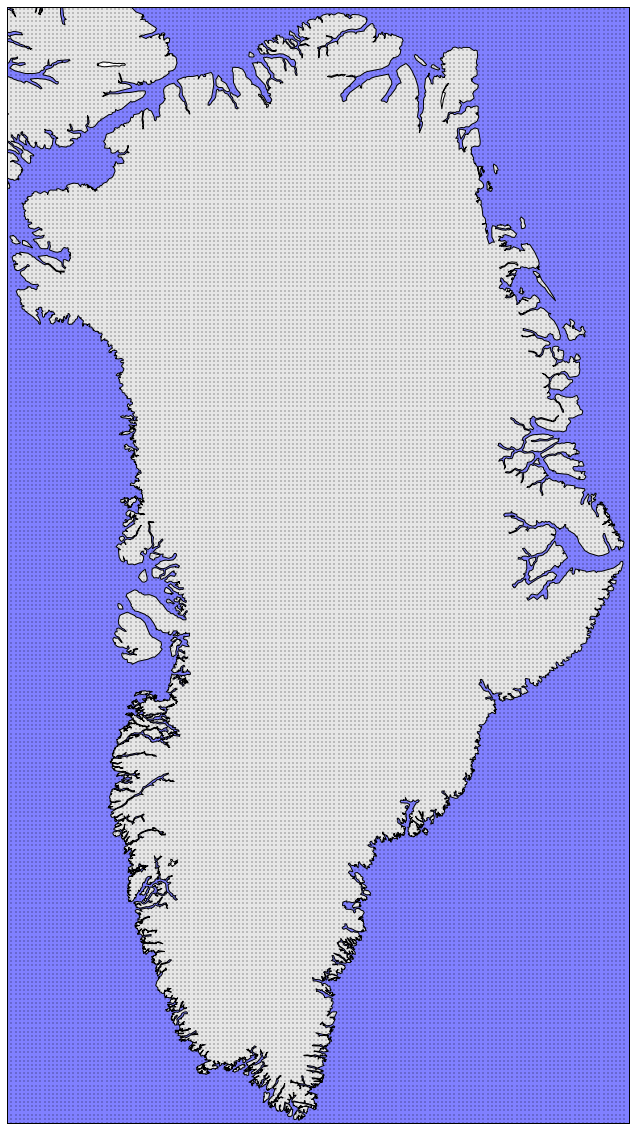

In [37]:
x0 = 640089.597677
y0 = 3355467.17938
map_xvals = xvals + x0
map_yvals = yvals + y0

fig = plt.figure(figsize=[20,20])
m = Basemap(projection='stere',lat_0=90.,lon_0=-45.,lat_ts=70.,ellps='WGS84',
              resolution='i',
              llcrnrlon=lon_ll, llcrnrlat=lat_ll, 
              urcrnrlon=lon_ur, urcrnrlat=lat_ur)

m.drawmapboundary(fill_color=[.5, .5, 1.0])
m.fillcontinents(color=[.9, .9, .9], lake_color='w',zorder=0)
m.drawcoastlines(color='k')
m.plot(map_xvals, map_yvals,'k.',markersize=.8)

plt.show()

As a quick test see how many points from the `gla06_034_grn` table would be found for each grid cell.  The array to store the results would be 135x75.  

In [38]:
def gridcell2poly(cellcntr, cellsize, epsgcode):
    """     
    Create a postGIS WKT Polygon geometry for a grid cell.  The cell
    center is given as a list of X and Y values.  The cell size is a
    list of dX and dY values.  The returned value is a string.
    
        Here's an example WKT Polygon string:

    ST_MakePolygon(
      ST_GeomFromText(
      'LINESTRING(75.15 29.53,77 29,77.6 29.5, 75.15 29.53)',
      4326));

    (I've added line breaks to make this readable.)

    """
    xcntr, ycntr = cellcntr
    deltax, deltay = cellsize

    points = [[xcntr-deltax, ycntr+deltay],
              [xcntr+deltax, ycntr+deltay],
              [xcntr+deltax, ycntr-deltay],
              [xcntr-deltax, ycntr-deltay],
              [xcntr-deltax, ycntr+deltay]]

    coordlist = ["{0} {1}".format(x[0], x[1]) for x in points]
    coordstr = ",".join(coordlist)
    polygeom = "ST_MakePolygon(ST_GeomFromText" + \
               "('LINESTRING({0})',{1}))".format( coordstr,
                                                  epsgcode)

    return polygeom

import psycopg2
import numpy as np

DBNAME = 'icedb'
DBHOST = 'icebridge.sr.unh.edu'
DBUSER = 'nobody'
DBPORT = '5432'
EPSG_CODE = 3413

# make database connection
conn_str = 'host={0} dbname={1} user={2}'.format(DBHOST, DBNAME, DBUSER)
try:
    conn = psycopg2.connect(conn_str)
except:
    print "connection to database failed"
    
outarr = np.zeros(xv.shape,np.int)
ny, nx = outarr.shape
cellsize = (grid_size, grid_size)
for j in range(ny):
    for i in range(nx):
        cellcntr = (xvals[i],yvals[j])
        bboxstr = gridcell2poly(cellcntr,cellsize,3413)

        # set up cursor for query
        mycur = conn.cursor()
        query = "select count(*) from gla06_034_grn where ST_Contains({0},the_geom) and wgs84surf is not null;"
        query = query.format(bboxstr)

        mycur.execute(query)
        results = mycur.fetchall()
        mycur.close()        

        outarr[j,i] = results[0][0]

In [39]:
outarr[0,0]

0

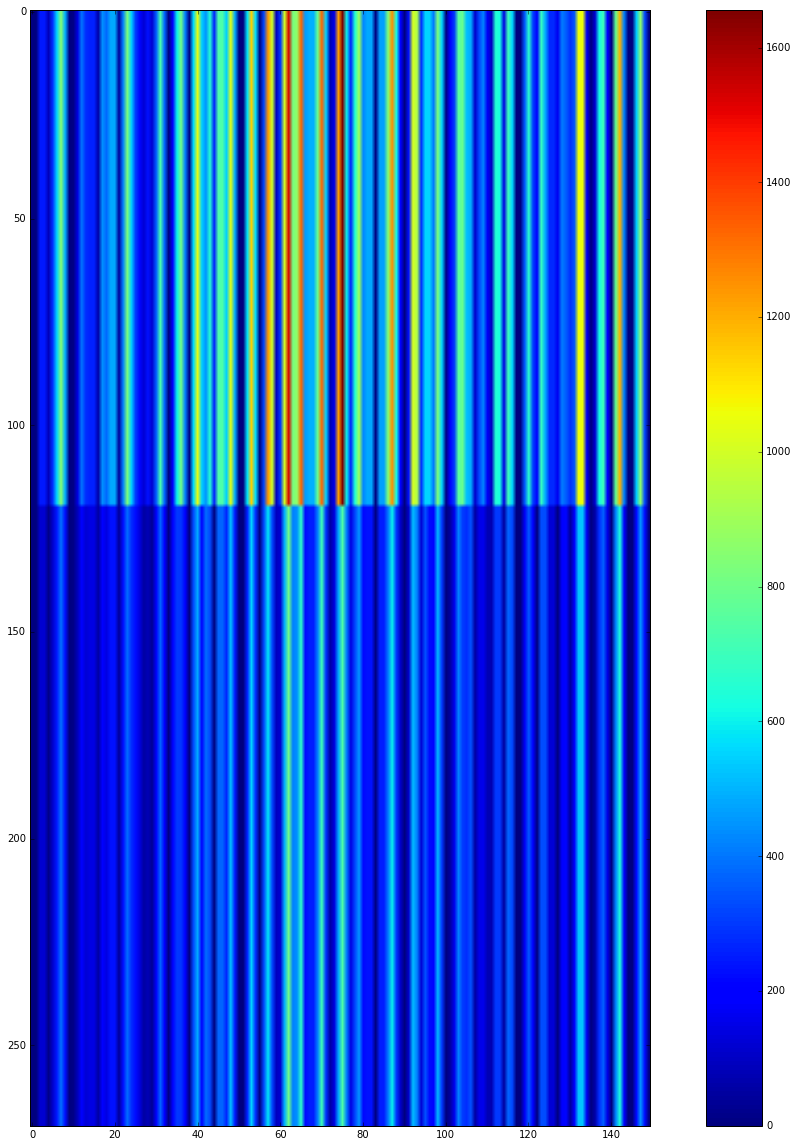

In [40]:
fig = plt.figure(figsize=[20,20])
plt.imshow(np.flipud(outarr), resample=False)
plt.colorbar()